# Исследование тарифов мобильного оператора

## Оглавление


<a name="All"></a>

* [1. Общая информация](#Step1)
* [2. Подготовка данных](#Step2)
* [3. Анализ данных](#Step3)
* [4. Проверка гипотез](#Step4)
* [5. Общий вывод](#Step5)

        Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
        Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

### Описание тарифов
###        Тариф «Смарт»
    Ежемесячная плата: 550 рублей
    Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
    Стоимость услуг сверх тарифного пакета:
        - минута разговора: 3 рубля
        - сообщение: 3 рубля
        - 1 Гб интернет-трафика: 200 рублей
###        Тариф «Ультра»
    Ежемесячная плата: 1950 рублей
    Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
    Стоимость услуг сверх тарифного пакета:
        - минута разговора: 1 рубль
        - сообщение: 1 рубль
        - 1 Гб интернет-трафика: 150 рублей
    Обратите внимание: «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.

  ###  Описание данных
  ### Таблица users (информация о пользователях):
  
   - user_id — уникальный идентификатор пользователя
   - first_name — имя пользователя
   - last_name — фамилия пользователя
   - age — возраст пользователя (годы)
   - reg_date — дата подключения тарифа (день, месяц, год)
   - churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
   - city — город проживания пользователя
   - tariff — название тарифного плана
   
### Таблица calls (информация о звонках):

   - id — уникальный номер звонка
   - call_date — дата звонка
   - duration — длительность звонка в минутах
   - user_id — идентификатор пользователя, сделавшего звонок
   
### Таблица messages (информация о сообщениях):

   - id — уникальный номер сообщения
   - message_date — дата сообщения
   - user_id — идентификатор пользователя, отправившего сообщение
   
### Таблица internet (информация об интернет-сессиях):

   - id — уникальный номер сессии
   - mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
   - session_date — дата интернет-сессии
   - user_id — идентификатор пользователя
   
### Таблица tariffs (информация о тарифах):

   - tariff_name — название тарифа
   - rub_monthly_fee — ежемесячная абонентская плата в рублях
   - minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
   - messages_included — количество сообщений в месяц, включённых в абонентскую плату
   - mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
   - rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
   - rub_per_message — стоимость отправки сообщения сверх тарифного пакета
   - rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

### <a name="Step1"></a> Шаг 1. Откройте файл с данными и изучите общую информацию.  

[Наверх](#All)

In [1]:
import pandas as pd
import numpy as np
from math import ceil
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

In [3]:
users.head(3)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [5]:
calls.head(3)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000


In [6]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [7]:
internet.head(3)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000


In [8]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [9]:
internet.head(3)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000


In [10]:
messages.head(3)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000


In [11]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Поменять тип данных где дата на datetime. Убрать лишний столбец из таблички internet.

## <a name="Step2"></a> 2. Подготовка данных

[Наверх](#All)

Удаляем лишний столбец из таблички internet

In [12]:
internet = internet.drop('Unnamed: 0', axis=1)

Надо преобразовать столбцы с датами в формат 'datetime'. Затем выделим из даты месяц и запишем в отдельный столбец 'month'.

In [13]:
calls['call_date'] = pd.to_datetime(calls['call_date'])
messages['message_date'] = pd.to_datetime(messages['message_date'])
internet['session_date'] = pd.to_datetime(internet['session_date'])

In [14]:
calls['month'] = calls['call_date'].dt.month
messages['month'] = messages['message_date'].dt.month
internet['month'] = internet['session_date'].dt.month

Для удобства подсчета количества звонков, количества сообщений и юзеров создадим отдельные столбцы в нужных табличках.

In [15]:
messages['messages_count'] = 1
calls['calls_count'] = 1
users['user_count'] = 1

Приведем звонки и мегабайты к целым округлив до верхнего значения посредством функции 'ceil'.

In [16]:
calls['duration'] = calls['duration'].apply(ceil)
internet['mb_used'] = internet['mb_used'].apply(ceil)

Просуммируем помесячно и по юзерам, потраченные мегабайты, длительность звонков и количество сообщений.

In [17]:
internet_s = internet.groupby(['user_id','month']).sum().reset_index()
calls_s = calls.groupby(['user_id','month']).sum().reset_index()
messages_s = messages.groupby(['user_id','month']).sum().reset_index()

На данном этапе из таблички users нам ны только city, user_id и tariff, поэтому делаем новую табличку.

In [18]:
users_s = users[['user_id','tariff','city']]

Складываем все данные в новую табличку.

In [19]:
users_s = calls_s.merge(users_s,how='outer',on=['user_id'])
users_s = internet_s.merge(users_s,how='outer',on=['user_id','month'])
users_s = messages_s.merge(users_s,how='outer',on=['user_id','month'])

In [20]:
users_s

,user_id,month,messages_count,mb_used,duration,calls_count,tariff,city
0,1000,5.0,22.0,2256.0,159.0,22.0,ultra,Краснодар
1,1000,6.0,60.0,23257.0,172.0,43.0,ultra,Краснодар
2,1000,7.0,75.0,14016.0,340.0,47.0,ultra,Краснодар
3,1000,8.0,81.0,14070.0,408.0,52.0,ultra,Краснодар
4,1000,9.0,57.0,14581.0,466.0,58.0,ultra,Краснодар
...,...,...,...,...,...,...,...,...
3217,1231,NaN,NaN,NaN,NaN,NaN,ultra,Чебоксары
3218,1328,NaN,NaN,NaN,NaN,NaN,ultra,Мурманск
3219,1371,NaN,NaN,NaN,NaN,NaN,smart,Омск
3220,1473,NaN,NaN,NaN,NaN,NaN,ultra,Красноярск


In [21]:
users_s.isna().sum()

user_id             0
month               8
messages_count    505
mb_used            19
duration           48
calls_count        48
tariff             40
city               40
dtype: int64

Записи с пустым месяцем откинем, их мало, остальные заполним нулями - люди не пользуются данными услугами.

In [22]:
# users_s['mb_used'] = users_s['mb_used'].fillna(0)
# users_s['calls_count'] = users_s['calls_count'].fillna(0)
# users_s['duration'] = users_s['duration'].fillna(0)
# users_s['messages_count'] = users_s['messages_count'].fillna(0)
# users_s = users_s[users_s['month'].notna()]

In [23]:
# с пропусками
pd.Series([200, 300, 256] + [np.nan]*9).mean()

252.0

In [24]:
# без пропусками, с 0
pd.Series([200, 300, 256] + [0]*9).mean()

63.0

Посмотрим на пропуски:

In [25]:
users_s.isna().sum()

user_id             0
month               8
messages_count    505
mb_used            19
duration           48
calls_count        48
tariff             40
city               40
dtype: int64

In [26]:
users_s[users_s['month'].isna()]

,user_id,month,messages_count,mb_used,duration,calls_count,tariff,city
3214,1091,NaN,NaN,NaN,NaN,NaN,ultra,Набережные Челны
3215,1106,NaN,NaN,NaN,NaN,NaN,ultra,Калуга
3216,1128,NaN,NaN,NaN,NaN,NaN,ultra,Волжский
3217,1231,NaN,NaN,NaN,NaN,NaN,ultra,Чебоксары
3218,1328,NaN,NaN,NaN,NaN,NaN,ultra,Мурманск
3219,1371,NaN,NaN,NaN,NaN,NaN,smart,Омск
3220,1473,NaN,NaN,NaN,NaN,NaN,ultra,Красноярск
3221,1489,NaN,NaN,NaN,NaN,NaN,smart,Санкт-Петербург


In [27]:
users_s[users_s['tariff'].isna()].groupby('user_id').sum()

,month,messages_count,mb_used,duration,calls_count
user_id,,,,,
1091,68.0,272.0,107501.0,0.0,0.0
1106,72.0,225.0,156311.0,0.0,0.0
1231,68.0,1384.0,222731.0,0.0,0.0
1328,33.0,21.0,97475.0,0.0,0.0
1373,6.0,48.0,12457.0,0.0,0.0
1473,50.0,90.0,84051.0,0.0,0.0
1476,4.0,0.0,531.0,0.0,0.0
1489,50.0,125.0,82743.0,0.0,0.0


Это +/- одни и теже люди которых мы внизу приняли решение удалить из выборки т.к. они занимают незначительный процент в данных и не скажутся на анализе.

Если посмотреть подробнее на некоторых:

In [28]:
users[users['user_id'] == 1476]

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,user_count
476,1476,50,NaN,Москва,Валентина,Семенова,2018-04-30,ultra,1


In [29]:
users_s[users_s['user_id'] == 1476]

,user_id,month,messages_count,mb_used,duration,calls_count,tariff,city
2579,1476,5.0,7.0,21805.0,459.0,71.0,ultra,Москва
2580,1476,6.0,4.0,14634.0,491.0,62.0,ultra,Москва
2581,1476,7.0,3.0,16004.0,492.0,65.0,ultra,Москва
2582,1476,8.0,5.0,25128.0,456.0,59.0,ultra,Москва
2583,1476,9.0,5.0,18620.0,622.0,72.0,ultra,Москва
2584,1476,10.0,4.0,25148.0,540.0,68.0,ultra,Москва
2585,1476,11.0,6.0,14423.0,556.0,71.0,ultra,Москва
2586,1476,12.0,11.0,14136.0,588.0,81.0,ultra,Москва
3202,1476,4.0,NaN,531.0,NaN,NaN,NaN,NaN


Тут плохо зачелся первый месяц пользования тарифом.

In [30]:
users[users['user_id'] == 1473]

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,user_count
473,1473,18,NaN,Красноярск,Николай,Лебедев,2018-08-05,ultra,1


In [31]:
users_s[users_s['user_id'] == 1473]

,user_id,month,messages_count,mb_used,duration,calls_count,tariff,city
2560,1473,8.0,17.0,12917.0,NaN,NaN,NaN,NaN
2561,1473,9.0,19.0,17307.0,NaN,NaN,NaN,NaN
2562,1473,10.0,20.0,13703.0,NaN,NaN,NaN,NaN
2563,1473,11.0,14.0,21692.0,NaN,NaN,NaN,NaN
2564,1473,12.0,20.0,18432.0,NaN,NaN,NaN,NaN
3220,1473,NaN,NaN,NaN,NaN,NaN,ultra,Красноярск


А тут вообще непонятно как так получилось.

Ну и в итоге когда мы удалим пропуски по тарифам и месяцам - у нас не останется пользователей у которых есть пропуски в помесячной длительности разговоров.

In [32]:
users_s = users_s[users_s['tariff'].notna()]
users_s = users_s[users_s['month'].notna()]

In [33]:
users_s.isna().sum()

user_id             0
month               0
messages_count    496
mb_used            11
duration            0
calls_count         0
tariff              0
city                0
dtype: int64

In [34]:
users_s[users_s['mb_used'].isna()]

,user_id,month,messages_count,mb_used,duration,calls_count,tariff,city
1399,1273,5.0,21.0,NaN,220.0,24.0,ultra,Курган
1400,1273,6.0,38.0,NaN,230.0,40.0,ultra,Курган
1401,1273,7.0,37.0,NaN,253.0,44.0,ultra,Курган
1402,1273,8.0,41.0,NaN,253.0,53.0,ultra,Курган
1403,1273,9.0,32.0,NaN,223.0,33.0,ultra,Курган
1404,1273,10.0,35.0,NaN,315.0,40.0,ultra,Курган
1405,1273,11.0,29.0,NaN,272.0,45.0,ultra,Курган
1406,1273,12.0,39.0,NaN,260.0,41.0,ultra,Курган
1970,1377,2.0,2.0,NaN,179.0,23.0,ultra,Брянск
2075,1392,2.0,3.0,NaN,13.0,2.0,ultra,Челябинск


Для использованного интернета, тут 4 пользователя с незаполненными значениями, один из которых практически выбирает все число ошибок, а для остальных если заполнить 0 - мне кажется сильно не повлияет на окончательный анализ.

Мерджил таблички от написанных сообщений(звонков и мегабайтов) и в финальный результат, не должны попадать месяца с полностью по всем параметрам пропущенными значениями, т.е. не будет месяца до того как пользователь пришел на тариф. А если так - значит человек не пользовался сообщениями, поэтому заменяем 0. Заполнять каким то другим значением как мне кажется будет неправильно и исказит данные.

In [75]:
st.ttest_ind([10] * 10, [*range(30)])

Ttest_indResult(statistic=-1.6024522364766756, pvalue=0.11733684984533495)

1 выборка - 10 значений, 2 - 30 значений - test отработал нормально

In [35]:
users_s['mb_used'] = users_s['mb_used'].fillna(0)
users_s['messages_count'] = users_s['messages_count'].fillna(0)

Изучим данные пользователей без тарифов.

In [36]:
users_s[users_s['tariff'].isna()].mean()

user_id          NaN
month            NaN
messages_count   NaN
mb_used          NaN
duration         NaN
calls_count      NaN
tariff           NaN
city             NaN
dtype: float64

In [37]:
users_s[users_s['tariff'] == 'ultra'].mean()

user_id            1264.766562
month                 8.235542
messages_count       49.033649
mb_used           19480.544690
duration            545.451104
calls_count          76.016824
dtype: float64

In [38]:
users_s[users_s['tariff'] == 'smart'].mean()

user_id            1245.904184
month                 8.344130
messages_count       33.396311
mb_used           16230.166892
duration            419.062978
calls_count          58.621233
dtype: float64

In [39]:
users_s[users_s['tariff'].isna()].groupby('user_id').sum()

,month,messages_count,mb_used,duration,calls_count
user_id,,,,,


Все не пользуются связью, только интернетом и сообщениями, их немного и лучше удалить.

In [40]:
#users_s = users_s[users_s['tariff'].notna()]

Посчитаем месячную выручку для каждого абонента.

In [41]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [42]:
# для тарифа ultra 
def bill_u(a,b,c):
    a_ = a-tariffs.loc[1]['minutes_included']
    if a_ < 0: a_=0
    b_ = b-tariffs.loc[1]['messages_included']
    if b_ < 0: b_=0
    c_ = c-tariffs.loc[1]['mb_per_month_included']
    if c_ < 0: c_=0
    if c_ > 0:
        c_ = ceil(c_/1024)*tariffs.loc[1]['rub_per_gb']

    return a_ + b_ + c_ + tariffs.loc[1]['rub_monthly_fee']

# для тарифа smart    
def bill_s(a,b,c):  
    a_ = (a-tariffs.loc[0]['minutes_included'])*tariffs.loc[0]['rub_per_minute']
    if a_ < 0: a_=0
    b_ = (b-tariffs.loc[0]['messages_included'])*tariffs.loc[0]['rub_per_message']
    if b_ < 0: b_=0
    c_ = c-tariffs.loc[0]['mb_per_month_included']
    if c_ < 0: c_=0
    if c_ > 0:
        c_ = ceil(c_/1024)*tariffs.loc[0]['rub_per_gb']

    return a_ + b_ + c_ + tariffs.loc[0]['rub_monthly_fee']

In [43]:
users_s['bill'] = np.where(users_s['tariff'] == 'ultra',
                                        pd.Series(map(bill_u,users_s['duration'],
                                                      users_s['messages_count'],users_s['mb_used'])),
                                         pd.Series(map(bill_s,users_s['duration'],
                                                       users_s['messages_count'],users_s['mb_used'])))

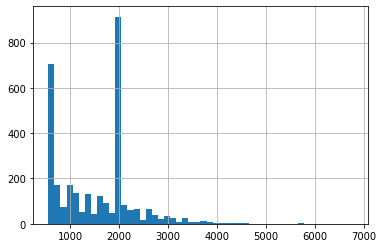

In [44]:
users_s['bill'].hist(bins=50)

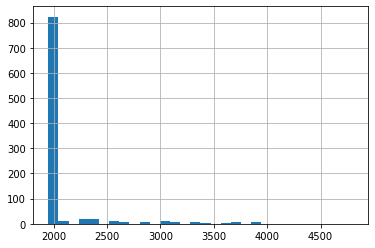

In [45]:
users_s[users_s['tariff'] == 'ultra']['bill'].hist(bins=30)

Поскольку лимиты у тарифа ultra весьма объемные пользователи перебирают их весьма редко.

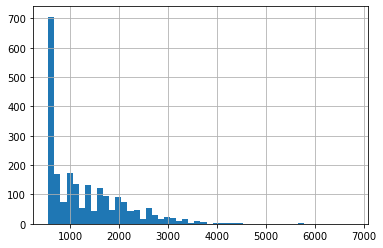

In [46]:
users_s[users_s['tariff'] == 'smart']['bill'].hist(bins=50)

Пользователи на тарифе smart частенько перебирают лимиты и платят больше, причем иногда намного больше чем пользователи с тарифом ultra. Возможно чтобы предотвратить отток клиентов следует клиентам которые регулярно и помногу перебирают предложить тариф ultra.

## <a name="Step3"></a> 3. Анализ данных


[Наверх](#All)

In [47]:
def graffik(cat):    
    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    sns.barplot(data=users_s[users_s['tariff'] == 'smart'].groupby('month').mean().reset_index(),
            x='month', 
            y=cat,
            dodge=False
           )
    plt.title('smart', fontsize=20)
    plt.subplot(1, 2, 2)
    sns.barplot(data=users_s[users_s['tariff'] == 'ultra'].groupby('month').mean().reset_index(),
            x='month', 
            y=cat,
            dodge=False
           )
    plt.title('ultra', fontsize=20)
    plt.show()

In [48]:
def histogr(cat,t1,t2):
    plt.figure(figsize=(14, 4))
    plt.hist(users_s[users_s['tariff'] == 'smart'].groupby('user_id').mean().reset_index()[cat], bins=15, color='c', edgecolor='k', alpha=0.5)
    
    plt.hist(users_s[users_s['tariff'] == 'ultra'].groupby('user_id').mean().reset_index()[cat], bins=15,color='g', edgecolor='k', alpha=0.5)
    plt.vlines(t1,0, 40)
    plt.vlines(t2,0, 40)
    plt.show()


In [49]:
users_s[users_s['tariff'] == 'ultra'].describe()

,user_id,month,messages_count,mb_used,duration,calls_count,bill
count,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000
mean,1264.766562,8.235542,49.033649,19480.544690,545.451104,76.016824,2071.924290
std,140.413405,2.883937,46.890656,10135.971146,306.925754,42.403348,382.106872
min,1000.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1950.000000
25%,1148.000000,6.000000,5.000000,11633.500000,310.000000,43.000000,1950.000000
50%,1281.000000,9.000000,39.000000,19374.000000,528.000000,75.000000,1950.000000
75%,1381.000000,11.000000,79.000000,26857.500000,756.500000,105.000000,1950.000000
max,1495.000000,12.000000,224.000000,49789.000000,1673.000000,244.000000,4800.000000


#### Среднее:

Сколько минут в месяц требуется абонентам?

In [50]:
print("Минут в среднем на тарифе smart:",users_s[users_s['tariff'] == 'smart'].describe().loc['mean']['duration'])
print("Минут в среднем на тарифе ultra:",users_s[users_s['tariff'] == 'ultra'].describe().loc['mean']['duration'])

Минут в среднем на тарифе smart: 419.0629779577148
Минут в среднем на тарифе ultra: 545.4511041009464


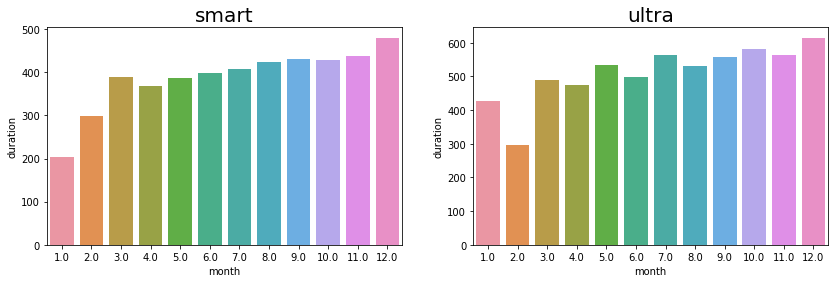

In [51]:
graffik('duration')

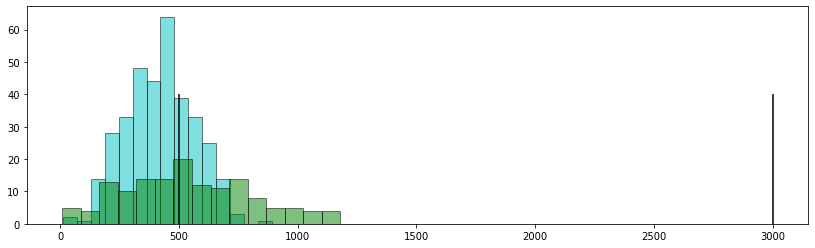

In [52]:
histogr('duration',tariffs['minutes_included'][0],tariffs['minutes_included'][1])

Юзеры на тарифе smart укладываются в лимит, пользователи на тарифе ultra в среднем сильно недобирают по длительности.

Сколько мегабайт требуется в месяц абонентам?

In [53]:
print("Мегабайт в среднем на тарифе smart:",users_s[users_s['tariff'] == 'smart'].describe().loc['mean']['mb_used'])
print("Мегабайт в среднем на тарифе ultra:",users_s[users_s['tariff'] == 'ultra'].describe().loc['mean']['mb_used'])

Мегабайт в среднем на тарифе smart: 16230.166891587944
Мегабайт в среднем на тарифе ultra: 19480.544689800212


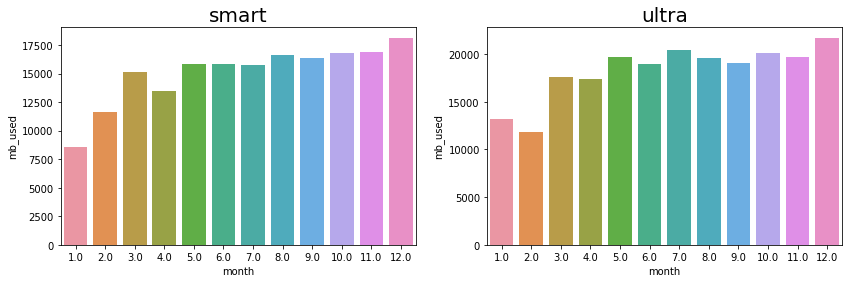

In [54]:
graffik('mb_used')

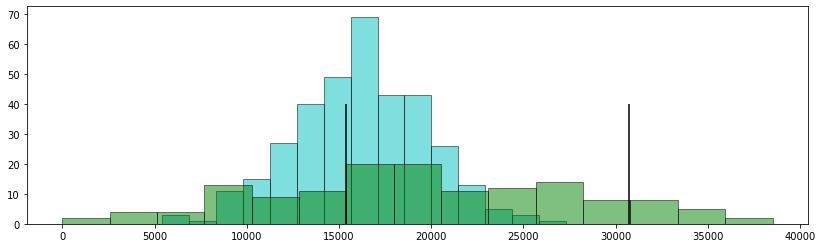

In [55]:
histogr('mb_used',tariffs['mb_per_month_included'][0],tariffs['mb_per_month_included'][1])

Юзеры на тарифе smart слегка перебирают лимит, на тарифе ultra ожидаемо недобирают.

Сколько сообщений в среднем требуется абонентам?

In [56]:
print("Сообщений в среднем на тарифе smart:",users_s[users_s['tariff'] == 'smart'].describe().loc['mean']['messages_count'])
print("Сообщений в среднем на тарифе ultra:",users_s[users_s['tariff'] == 'ultra'].describe().loc['mean']['messages_count'])

Сообщений в среднем на тарифе smart: 33.396311291048136
Сообщений в среднем на тарифе ultra: 49.03364879074658


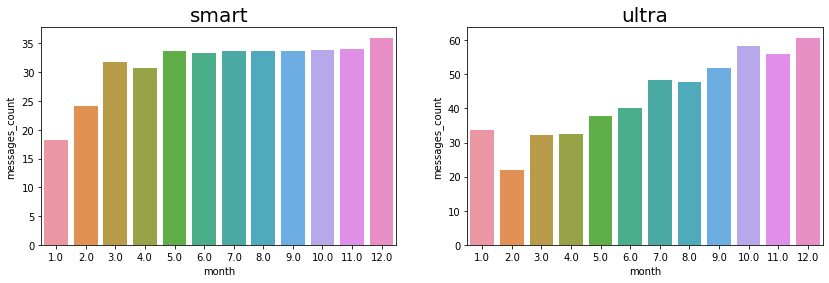

In [57]:
graffik('messages_count')

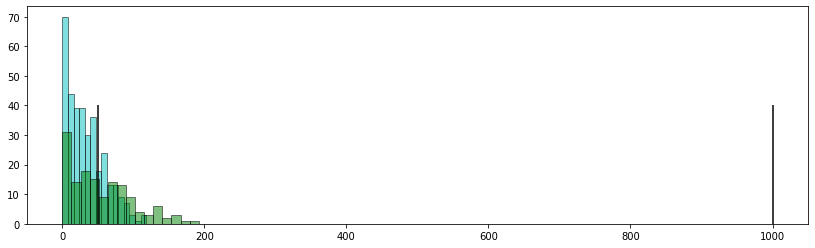

In [58]:
histogr('messages_count',tariffs['messages_included'][0],tariffs['messages_included'][1])

Сообщений не слишком много, на тарифе ультра чуть больше.

#### Стандартное отклонение:

In [59]:
print("Стандартное отклонение по минутам на тарифе smart:",users_s[users_s['tariff'] == 'smart'].describe().loc['std']['duration'])
print("Стандартное отклонение по минутам на тарифе ultra:",users_s[users_s['tariff'] == 'ultra'].describe().loc['std']['duration'])

Стандартное отклонение по минутам на тарифе smart: 189.3256177894154
Стандартное отклонение по минутам на тарифе ultra: 306.9257538821858


In [60]:
print("Стандартное отклонение по мегабайтам на тарифе smart:",users_s[users_s['tariff'] == 'smart'].describe().loc['std']['mb_used'])
print("Стандартное отклонение по мегабайтам на тарифе ultra:",users_s[users_s['tariff'] == 'ultra'].describe().loc['std']['mb_used'])

Стандартное отклонение по мегабайтам на тарифе smart: 5883.36304380904
Стандартное отклонение по мегабайтам на тарифе ultra: 10135.971146360018


In [61]:
print("Стандартное отклонение по сообщениям на тарифе smart:",users_s[users_s['tariff'] == 'smart'].describe().loc['std']['messages_count'])
print("Стандартное отклонение по сообщениям на тарифе ultra:",users_s[users_s['tariff'] == 'ultra'].describe().loc['std']['messages_count'])

Стандартное отклонение по сообщениям на тарифе smart: 28.259437219588445
Стандартное отклонение по сообщениям на тарифе ultra: 46.89065582191353


#### Дисперсия:

In [62]:
print('Дисперсия по сообщениям на тарифе smart:',users_s[users_s['tariff'] == 'smart'].describe().loc['std']['messages_count']**2)
print('Дисперсия по сообщениям на тарифе ultra:',users_s[users_s['tariff'] == 'ultra'].describe().loc['std']['messages_count']**2)

Дисперсия по сообщениям на тарифе smart: 798.5957919678607
Дисперсия по сообщениям на тарифе ultra: 2198.7336034091536


In [63]:
print('Дисперсия по мегабайтам на тарифе smart:',users_s[users_s['tariff'] == 'smart'].describe().loc['std']['mb_used']**2)
print('Дисперсия по мегабайтам на тарифе ultra:',users_s[users_s['tariff'] == 'ultra'].describe().loc['std']['mb_used']**2)

Дисперсия по мегабайтам на тарифе smart: 34613960.705257975
Дисперсия по мегабайтам на тарифе ultra: 102737911.07984282


In [64]:
print('Дисперсия по минутам на тарифе smart:',users_s[users_s['tariff'] == 'smart'].describe().loc['std']['duration']**2)
print('Дисперсия по минутам на тарифе ultra:',users_s[users_s['tariff'] == 'ultra'].describe().loc['std']['duration']**2)

Дисперсия по минутам на тарифе smart: 35844.1895513438
Дисперсия по минутам на тарифе ultra: 94203.41839614809


Количество юзеров по тарифам:

In [65]:
users.groupby('tariff').sum()

,user_id,age,user_count
tariff,,,
smart,436691,16306,351
ultra,188059,6988,149


## <a name="Step4"></a> 4. Проверка гипотез:

[Наверх](#All)

* средняя выручка пользователей тарифов «Ультра» и «Смарт» различается
* средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Выборки независимы между собой, можно использовать t-критерий.

Проверим первую гипотезу. Сформулируем гипотезу:

* H0: средняя выручка пользователей тарифов «Ультра» и «Смарт» не различается
* H1: средняя выручка пользователей тарифов «Ультра» и «Смарт» различается

In [66]:
smart = users_s[users_s['tariff'] == 'smart']['bill']
ultra = users_s[users_s['tariff'] == 'ultra']['bill']

In [67]:
alpha = 0.05

In [68]:
results = st.ttest_ind(ultra, smart)

In [69]:
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 3.824107073278515e-153
Отвергаем нулевую гипотезу


Средняя выручка отличается в достаточной степени что бы быть не случайной.

Проверим первую гипотезу. Сформулируем гипотезу:

* H0: средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов
* H1: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

In [70]:
other = users_s[users_s['city'] != 'Москва']['bill']
moscow = users_s[users_s['city'] == 'Москва']['bill']

In [71]:
results = st.ttest_ind(moscow, other)
alpha = 0.05

In [72]:
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.4516335152984994
Не получилось отвергнуть нулевую гипотезу


Средняя московская выручка недостаточно сильно отличается от средней выручки из регионов.

## <a name="Step5"></a> 5. Общий вывод

[Наверх](#All)

* Нельзя ответить какой тариф лучше, разным пользователям нужен разный обьем услуг.

* На тарифе smart пользователи по минутам в среднем подходят к границе лимита и постоянно слегка перебирают лимиты интернета, сообщениями мало кто пользуется. 
   
* На тарифе ultra пользователи по минутам прилично недобирают и небобирают около 10 гигабайт интернета, сообщения тоже мало кому интересны.

* Оператору как мне кажется следует пересмотреть свои тарифы, добавить минут и мегабайт в тариф smart, либо сделать подобный smart'у тариф дороже но с 25-50% увеличением лимитов, пользователи тарифа ultra сильно недобирают до лимитов и это тоже может показаться кому-то избыточным и пользователи пойдут искать более оптимальный тариф к конкурентам.

* Средняя выручка по пользователям тарифов ultra и smart различна.

* Средняя выручка из Москвы и регионов примерно похожа.

* Открытые личные данные в датасетах - моветон и следует позаботится об их удалении.